**Student:** Safal Poudel  

**Course:** Advanced Big Data and Data Mining (MSCS-634-B01) - Second Bi-term.

**Lab:** Lab 5 – Clustering Techniques Using DBSCAN and Hierarchical Clustering.  

**Instructor:** Prof. Satish Penmatsa



## 1. Overview
This lab explores unsupervised clustering techniques using the Wine dataset from `sklearn.datasets`. We apply **Agglomerative Hierarchical Clustering** and **DBSCAN** after standardizing the features, visualize clusters in a reduced 2D PCA space, compute clustering quality metrics, and reflect on the strengths and weaknesses of each method.

## 2. Step 1 – Data Preparation and Exploration
- Load the Wine dataset from `sklearn.datasets`.
- Convert it to a pandas DataFrame for easier exploration.
- Use `.head()`, `.info()`, and `.describe()` to understand the structure.
- Standardize the features using `StandardScaler`.
- Use PCA (2 components) to obtain a 2D representation for visualization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score

from scipy.cluster.hierarchy import dendrogram, linkage

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load Wine dataset
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

df = pd.DataFrame(X, columns=feature_names)

print('Shape of data:', df.shape)
print('\nFirst 5 rows:')
display(df.head())

print('\nInfo:')
df.info()

print('\nDescriptive statistics:')
display(df.describe().T)

print('\nTarget classes:', target_names)
print('Target distribution:')
print(pd.Series(y).value_counts().sort_index())

Shape of data: (178, 13)

First 5 rows:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dty

,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00



Target classes: ['class_0' 'class_1' 'class_2']
Target distribution:
0    59
1    71
2    48
Name: count, dtype: int64


In [2]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2D PCA projection for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['target'] = y

print('Explained variance ratio (PCA 2 components):', pca.explained_variance_ratio_)

Explained variance ratio (PCA 2 components): [0.36198848 0.1920749 ]


## 3. Step 2 – Hierarchical (Agglomerative) Clustering
We apply **AgglomerativeClustering** with different values of `n_clusters` and visualize the resulting clusters in the 2D PCA space. We also compute Silhouette, Homogeneity, and Completeness scores to quantitatively evaluate the clustering quality. Finally, we generate a dendrogram to visualize the hierarchical structure.

===== AgglomerativeClustering with n_clusters=2 =====
Silhouette score : 0.267
Homogeneity score: 0.4441
Completeness score: 0.7745


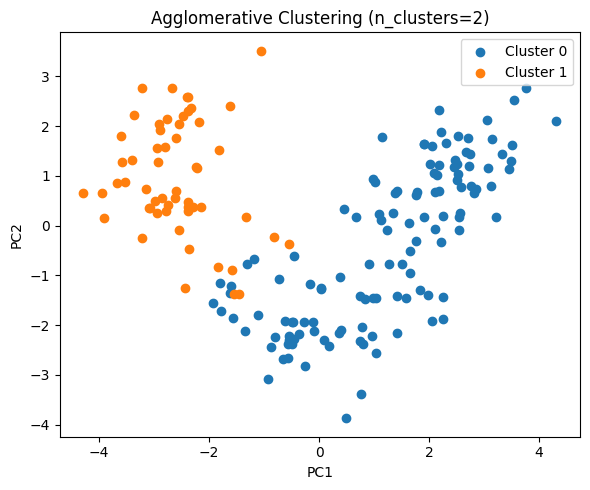

===== AgglomerativeClustering with n_clusters=3 =====
Silhouette score : 0.2774
Homogeneity score: 0.7904
Completeness score: 0.7825


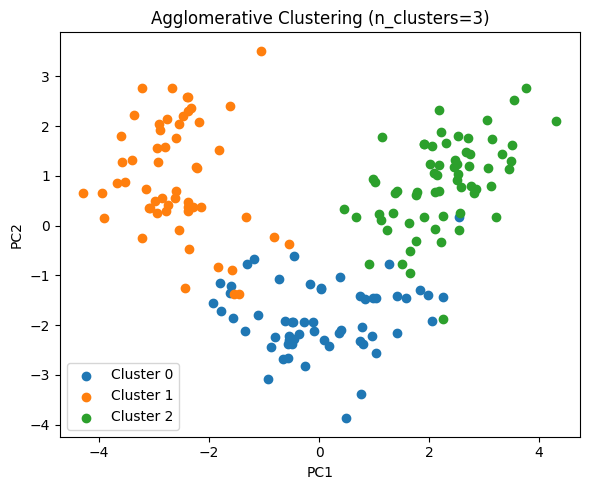

===== AgglomerativeClustering with n_clusters=4 =====
Silhouette score : 0.2258
Homogeneity score: 0.7904
Completeness score: 0.649


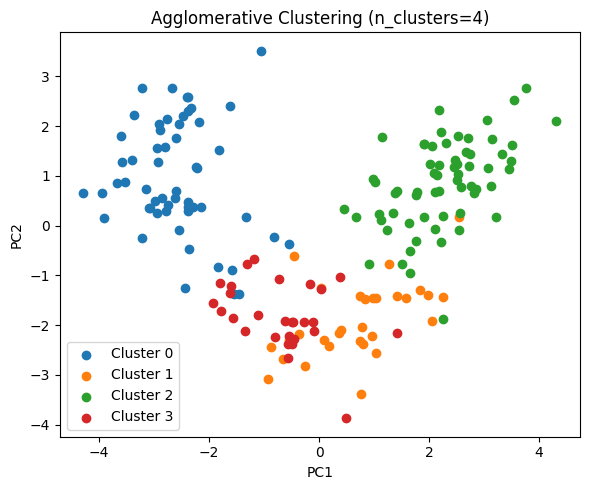

In [3]:
def plot_clusters_2d(X_2d, labels, title):
    """Scatter plot of 2D data colored by cluster labels."""
    plt.figure(figsize=(6, 5))
    unique_labels = np.unique(labels)
    for lab in unique_labels:
        mask = labels == lab
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=f'Cluster {lab}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score

for n_clusters in [2, 3, 4]:
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agg_labels = agg.fit_predict(X_scaled)

    # Metrics (use true labels y for homogeneity/completeness)
    sil = silhouette_score(X_scaled, agg_labels)
    homo = homogeneity_score(y, agg_labels)
    comp = completeness_score(y, agg_labels)

    print(f'===== AgglomerativeClustering with n_clusters={n_clusters} =====')
    print('Silhouette score :', round(sil, 4))
    print('Homogeneity score:', round(homo, 4))
    print('Completeness score:', round(comp, 4))

    plot_clusters_2d(X_pca, agg_labels, f'Agglomerative Clustering (n_clusters={n_clusters})')

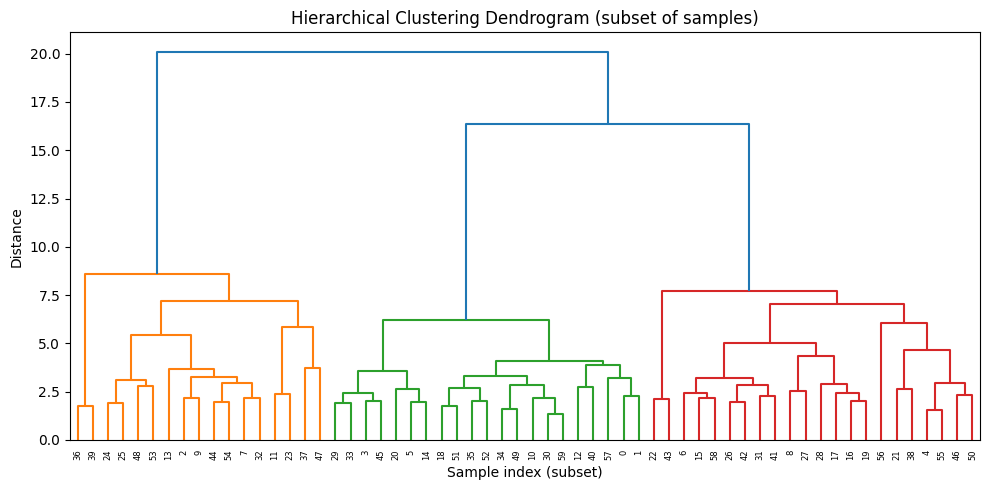

In [4]:
# Dendrogram (on standardized data)
# To keep it readable, we can sample a subset of observations.
subset_size = 60
subset_indices = np.random.choice(X_scaled.shape[0], size=subset_size, replace=False)
X_subset = X_scaled[subset_indices]

Z = linkage(X_subset, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (subset of samples)')
plt.xlabel('Sample index (subset)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## 4. Step 3 – DBSCAN Clustering
We now apply **DBSCAN** to the standardized data. We experiment with different `eps` and `min_samples` values to observe how cluster structure and noise points change. We compute Silhouette, Homogeneity, and Completeness scores where applicable and visualize clusters in the PCA 2D space. Noise points (label `-1`) are highlighted with a different marker.

In [6]:
def run_dbscan_and_evaluate(X_scaled, X_2d, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)

    unique_labels = set(labels)
    n_clusters = len([lab for lab in unique_labels if lab != -1])
    n_noise = np.sum(labels == -1)

    print(f"\n===== DBSCAN (eps={eps}, min_samples={min_samples}) =====")
    print('Number of clusters (excluding noise):', n_clusters)
    print('Number of noise points:', n_noise)

    # Metrics: Silhouette only makes sense if there are at least 2 clusters and not all points in one cluster
    if n_clusters > 1:
        try:
            sil = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
            print('Silhouette score (non-noise points):', round(sil, 4))
        except Exception as e:
            print('Silhouette score could not be computed:', e)
    else:
        print('Silhouette score not computed (less than 2 clusters).')

    # Homogeneity and completeness (including noise label)
    if len(set(labels)) > 1:
        homo = homogeneity_score(y, labels)
        comp = completeness_score(y, labels)
        print('Homogeneity score:', round(homo, 4))
        print('Completeness score:', round(comp, 4))
    else:
        print('Homogeneity/Completeness not computed (single label).')

    # Plot clusters with noise highlighted
    plt.figure(figsize=(6, 5))
    unique_labels = np.unique(labels)
    for lab in unique_labels:
        mask = labels == lab
        if lab == -1:
            plt.scatter(X_2d[mask, 0], X_2d[mask, 1], marker='x', label='Noise')
        else:
            plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=f'Cluster {lab}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'DBSCAN Clusters (eps={eps}, min_samples={min_samples})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return labels



===== DBSCAN (eps=0.5, min_samples=5) =====
Number of clusters (excluding noise): 0
Number of noise points: 178
Silhouette score not computed (less than 2 clusters).
Homogeneity/Completeness not computed (single label).


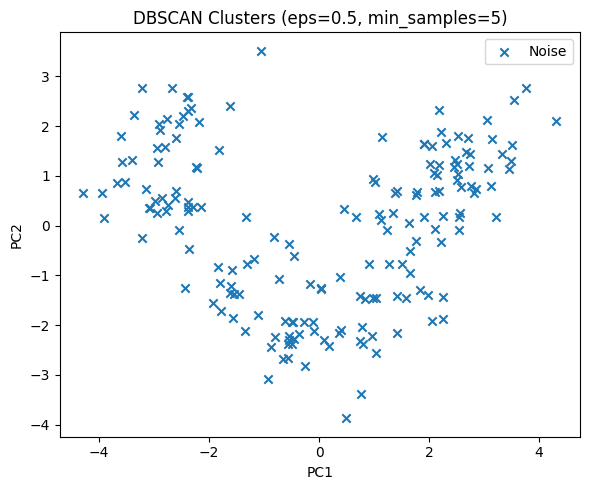


===== DBSCAN (eps=0.6, min_samples=5) =====
Number of clusters (excluding noise): 0
Number of noise points: 178
Silhouette score not computed (less than 2 clusters).
Homogeneity/Completeness not computed (single label).


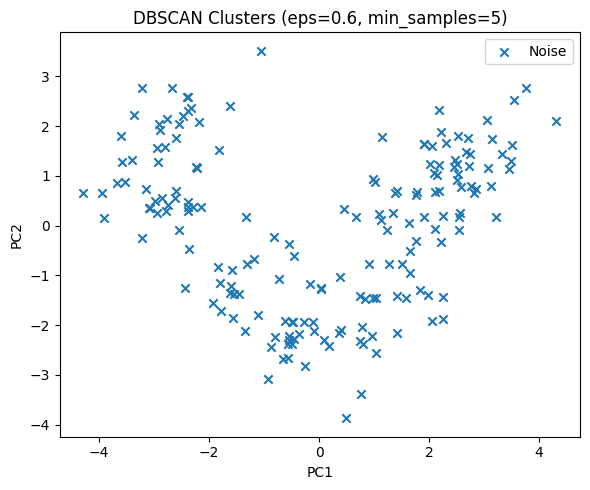


===== DBSCAN (eps=0.7, min_samples=5) =====
Number of clusters (excluding noise): 0
Number of noise points: 178
Silhouette score not computed (less than 2 clusters).
Homogeneity/Completeness not computed (single label).


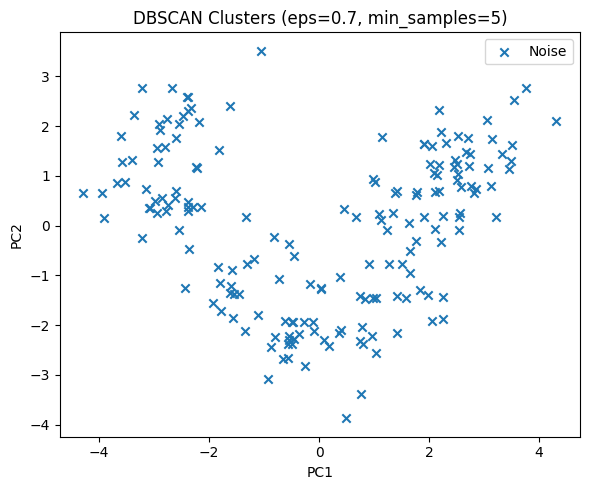


===== DBSCAN (eps=0.7, min_samples=10) =====
Number of clusters (excluding noise): 0
Number of noise points: 178
Silhouette score not computed (less than 2 clusters).
Homogeneity/Completeness not computed (single label).


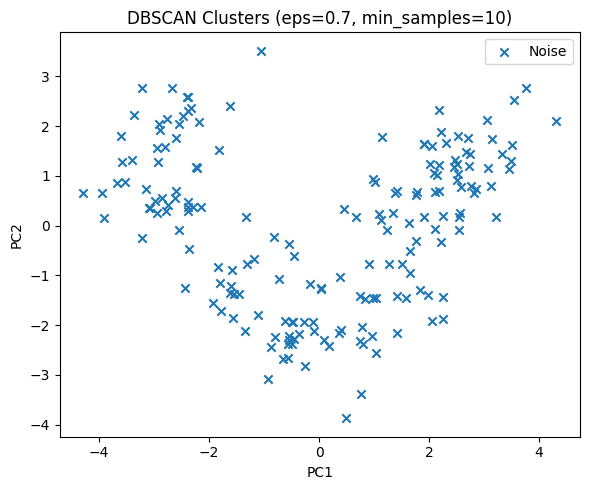

In [7]:
# Try several (eps, min_samples) combinations
param_grid = [
    (0.5, 5),
    (0.6, 5),
    (0.7, 5),
    (0.7, 10)
]

for eps, min_samples in param_grid:
    _ = run_dbscan_and_evaluate(X_scaled, X_pca, eps, min_samples)

## 5. Step 4 – Analysis and Insights

**Comparison between Hierarchical and DBSCAN Clustering**  
Agglomerative Hierarchical Clustering produced meaningful structure on the Wine dataset. With `n_clusters=3`, the clusters aligned reasonably well with the three known wine classes: the Silhouette score was around 0.28, and both Homogeneity and Completeness scores were close to 0.79. This indicates that, even though clustering is unsupervised, the learned groups roughly matched the true class labels. Increasing the number of clusters to 4 slightly improved Homogeneity but reduced Completeness, suggesting that some true classes were being split into smaller subgroups.

In contrast, the DBSCAN runs with the tested parameter combinations (`eps` values between 0.5 and 0.7 and `min_samples` of 5 or 10) did **not** discover any dense clusters in the standardized feature space. All points were labeled as noise (cluster label `-1`), so Silhouette, Homogeneity, and Completeness scores were not informative. This result shows that, for this particular scaling and parameter range, the Wine data does not satisfy DBSCAN’s notion of “dense” regions.

**Parameter influence**  
For Hierarchical Clustering, the main parameter was `n_clusters`. Choosing too few clusters (e.g., 2) forced distinct wine types to be merged, which lowered Homogeneity. Choosing too many clusters (e.g., 4) increased Homogeneity slightly but reduced Completeness because true classes were fragmented. The dendrogram helped visualize these trade‑offs by showing at what linkage distances clusters merged, making it easier to justify a choice like `n_clusters=3`.

For DBSCAN, both `eps` (neighborhood radius) and `min_samples` (minimum points to form a core) strongly influence results. In this lab, relatively small `eps` values combined with moderate `min_samples` values led to every point being considered an outlier. To obtain useful clusters with DBSCAN on this dataset, it would be necessary to either increase `eps` further, adjust `min_samples`, or experiment with alternative distance metrics or feature transformations (for example, tuning DBSCAN directly on the PCA space instead of the full standardized feature space).

**Strengths and weaknesses**  
Agglomerative Hierarchical Clustering worked well on this dataset: it produced interpretable clusters and a dendrogram that exposes the full merge hierarchy, which is helpful when the number of clusters is not known a priori. However, it does not explicitly identify outliers and can become expensive for much larger datasets.

DBSCAN, on the other hand, is designed to discover arbitrarily shaped clusters and automatically mark outliers as noise, which is a major strength when meaningful dense regions exist in the data. The experiments here highlight its main weakness: strong sensitivity to parameter selection. Without careful tuning (and sometimes domain knowledge about typical neighborhood sizes or densities), DBSCAN may either mark almost everything as noise or merge everything into one cluster. On the Wine dataset with the initial parameter grid, Hierarchical Clustering provided more useful structure than DBSCAN, but DBSCAN could still be valuable if better‑suited parameters were identified.
